# Dementia (임상 치매 환자 판별 및 설문지 재구성)
 - <a href="Dementia.pptx"> 발표자료 </a>
 
### 치매를 보다 신속하게 진단/선별하는 방법을 모색한다
        << 현황 >> 
  - 총 117문항으로 이루어진 선별 검사의 긴 소요시간으로 인한 컴플레인 발생, 기회비용 발생
    
        << 목표 >> 
  - 최소한의 소요시간과 최대한의 정확도로 치매 환자 예측 기법 발굴 ⇒ 최소화한 선별 검사로 선별력 향상도에 기여

<img src="1.PNG" width=700>
<img src="2.PNG" width=700>
<img src="3.PNG" width=700>
<img src="4.PNG" width=700>

- KDSQ:Korean Dementia Screen Questionnaire- 보호자용 설문지
- SIADL:Seoul Instrumental Activities of Daily Living- 도구적 일상생활능력평가지
- NPI:Neuropsychistric Inventory- 신경정신과적 증상 평가지
- MMSE:Meni-Mental State Examination- 환자용 평가지
- KGDS:Korean Geriatric Depression Scale- 한국형 노인우울증 평가지

In [30]:
library(psych) ; library(GPArotation) ; library(lattice) ; library(caret)
library(C50) ; library(ROCR) ; library(e1071) ; library(Epi) ; library(pROC)
library(ggplot2) ; library(scales) ; library(plyr) ; library(reshape2)
library(RColorBrewer) ; library(gridExtra)

In [2]:
NP_test <- read.csv("data/NP_test.csv", header = TRUE)
head(NP_test)

,id,Dx_str,Dx,Dx1,Dx2,Gender,Education,Age,Date,Smoking,...,MMSE_R,MMSE_Or_time,MMSE_Or_place,MMSE_regist,MMSE_att,MMSE_recall,MMSE_lang,KDSQ_mem,KDSQ_others,KDSQ_ADL
1,1,dementia,2,1,1,0,0,72,2006-03-29,0,...,12,4,4,3,0,0,7,4,6,2
2,2,dementia,2,1,1,0,6,68,2006-03-29,0,...,10,3,5,3,0,0,9,6,3,0
3,3,dementia,2,1,1,0,0,79,2006-04-21,0,...,12,3,2,3,0,3,7,8,6,4
4,4,dementia,2,1,1,0,6,73,2006-04-21,0,...,15,1,3,3,0,0,8,8,4,5
5,5,dementia,2,1,1,0,0,76,2006-05-02,0,...,22,0,1,2,0,0,5,9,6,8
6,6,dementia,2,1,1,0,9,79,2006-05-12,1,...,15,1,3,3,2,0,6,10,6,7


## 범주형 자료 변환 

#### 성별 

In [3]:
NP_test$Gender <- factor(NP_test$Gender, labels = c("Female", "Male")) #성별

#### 진단명 

In [4]:
NP_test$Dx <- factor(NP_test$Dx, labels = c("control", "MCI", "dementia")) #진단명 
NP_test$Dx1 <- factor(NP_test$Dx1, labels = c("control", "Cog dysfunc"))
NP_test$Dx2 <- factor(NP_test$Dx2, labels = c("control", "dementia"))

#### 기타 

In [5]:
NP_test$Smoking <- factor(NP_test$Smoking, labels = c("none", "current smoker")) #흡연
NP_test$FHx_dementia <- factor(NP_test$FHx_dementia, labels = c("none", "Family history of dementia")) # 치매 가족력
NP_test$Diabetes <- factor(NP_test$Diabetes, labels = c("none", "Diabetes mellitus")) #당뇨병
NP_test$HTN <- factor(NP_test$HTN, labels = c("none", "Hypertension")) # 고혈압
NP_test$Dyslipid <- factor(NP_test$Dyslipid, labels =c("none", "Dyslipidemia")) # 고지혈증
NP_test$Heart <- factor(NP_test$Heart, labels = c("none", "Heart disease")) # 심장병
NP_test$Stroke <- factor(NP_test$Stroke, labels = c("none", "Stroke")) # 뇌졸증

In [6]:
head(NP_test)

,id,Dx_str,Dx,Dx1,Dx2,Gender,Education,Age,Date,Smoking,...,MMSE_R,MMSE_Or_time,MMSE_Or_place,MMSE_regist,MMSE_att,MMSE_recall,MMSE_lang,KDSQ_mem,KDSQ_others,KDSQ_ADL
1,1,dementia,dementia,Cog dysfunc,dementia,Female,0,72,2006-03-29,none,...,12,4,4,3,0,0,7,4,6,2
2,2,dementia,dementia,Cog dysfunc,dementia,Female,6,68,2006-03-29,none,...,10,3,5,3,0,0,9,6,3,0
3,3,dementia,dementia,Cog dysfunc,dementia,Female,0,79,2006-04-21,none,...,12,3,2,3,0,3,7,8,6,4
4,4,dementia,dementia,Cog dysfunc,dementia,Female,6,73,2006-04-21,none,...,15,1,3,3,0,0,8,8,4,5
5,5,dementia,dementia,Cog dysfunc,dementia,Female,0,76,2006-05-02,none,...,22,0,1,2,0,0,5,9,6,8
6,6,dementia,dementia,Cog dysfunc,dementia,Female,9,79,2006-05-12,current smoker,...,15,1,3,3,2,0,6,10,6,7


In [7]:
str(NP_test)

'data.frame':	11902 obs. of  119 variables:
 $ id           : int  1 2 3 4 5 6 7 8 9 10 ...
 $ Dx_str       : Factor w/ 3 levels "control","dementia",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ Dx           : Factor w/ 3 levels "control","MCI",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ Dx1          : Factor w/ 2 levels "control","Cog dysfunc": 2 2 2 2 2 2 2 2 2 2 ...
 $ Dx2          : Factor w/ 2 levels "control","dementia": 2 2 2 2 2 2 2 2 2 2 ...
 $ Gender       : Factor w/ 2 levels "Female","Male": 1 1 1 1 1 1 1 2 1 1 ...
 $ Education    : int  0 6 0 6 0 9 0 6 0 0 ...
 $ Age          : int  72 68 79 73 76 79 84 77 80 66 ...
 $ Date         : Factor w/ 1627 levels "2005-01-18","2005-02-28",..: 116 116 134 134 141 148 162 171 173 173 ...
 $ Smoking      : Factor w/ 2 levels "none","current smoker": 1 1 1 1 1 2 1 2 2 1 ...
 $ FHx_dementia : Factor w/ 2 levels "none","Family history of dementia": 1 1 1 1 1 1 1 1 1 1 ...
 $ Diabetes     : Factor w/ 2 levels "none","Diabetes mellitus": 2 1 1 1 1 2 1 1 1 1 ...
 $ 

# 1-1 분석 대상의 인구학적 특징 

In [8]:
summary(NP_test[,c(3:8, 10:15)]) #진단명, 성별/교육/나이, 위험인자 분포 

        Dx                Dx1              Dx2          Gender    
 control :1291   control    : 1291   control :1291   Female:7910  
 MCI     :4145   Cog dysfunc:10611   dementia:6466   Male  :3992  
 dementia:6466                       NA's    :4145                
                                                                  
                                                                  
                                                                  
   Education           Age                  Smoking     
 Min.   : 0.000   Min.   :50.00   none          :10972  
 1st Qu.: 3.000   1st Qu.:67.00   current smoker:  930  
 Median : 6.000   Median :73.00                         
 Mean   : 7.266   Mean   :72.25                         
 3rd Qu.:12.000   3rd Qu.:78.00                         
 Max.   :25.000   Max.   :96.00                         
                     FHx_dementia               Diabetes              HTN      
 none                      :9705   none             

In [9]:
Tmp_Graph <- NP_test[,c(3:8, 10:16)]

In [10]:
g1 <- ggplot(Tmp_Graph, aes(x=Dx1)) + geom_bar()
g2 <- ggplot(Tmp_Graph, aes(x=Dx2)) + geom_bar()
g3 <- ggplot(Tmp_Graph, aes(x=Gender)) + geom_bar()
g4 <- ggplot(Tmp_Graph, aes(x="Education", y=Education))+geom_boxplot()
g5 <- ggplot(Tmp_Graph, aes(x="Age", y = Age)) + geom_boxplot()
g6 <- ggplot(Tmp_Graph, aes(x=FHx_dementia)) + geom_bar()
g7 <- ggplot(Tmp_Graph, aes(x=Diabetes)) + geom_bar()
g8 <- ggplot(Tmp_Graph, aes(x=HTN)) + geom_bar()
g9 <- ggplot(Tmp_Graph, aes(x=Dyslipid)) + geom_bar()
g10 <- ggplot(Tmp_Graph, aes(x=Heart)) + geom_bar()
g11 <- ggplot(Tmp_Graph, aes(x=Stroke)) + geom_bar()

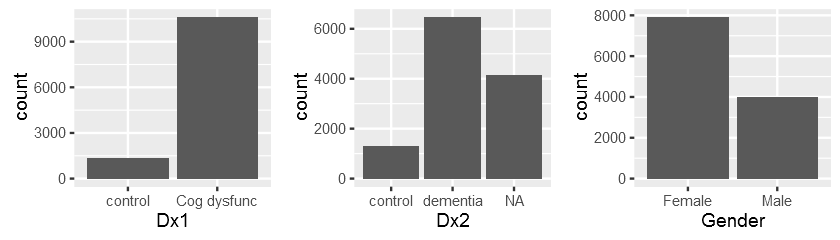

In [11]:
options(repr.plot.height=2)
grid.arrange( g1, g2, g3, nrow=1)

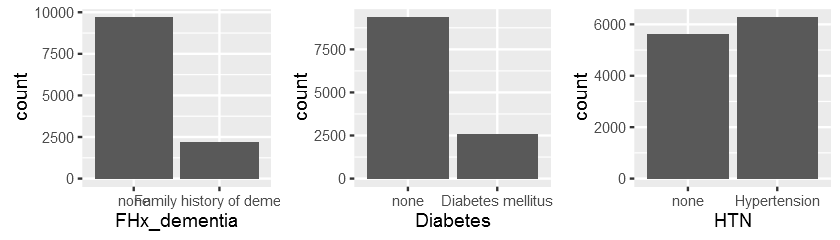

In [12]:
grid.arrange( g6, g7, g8, nrow=1)

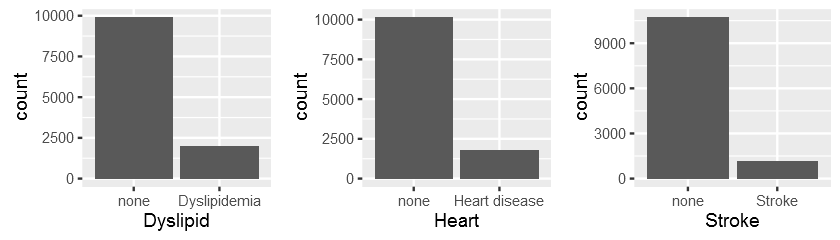

In [13]:
grid.arrange( g9, g10, g11, nrow=1)

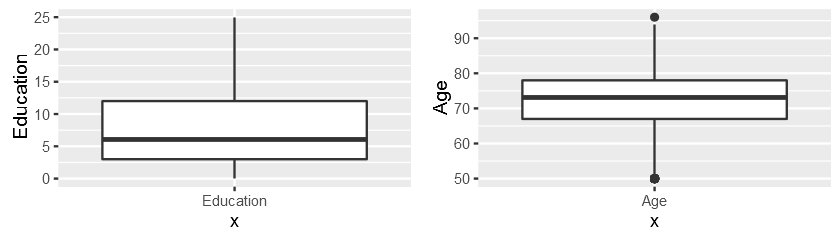

In [14]:
grid.arrange( g4, g5, nrow=1)

# 1-2 주요 인지기능검사 분포 

In [15]:
summary(NP_test[,c(89,106:109)]) #MMSE[,89], MMSE-R[,110]

      MMSE         KDSQ_total  SIADL_total      NPI_total        KGDS_total    
 Min.   : 0.00   Min.   : 0   Min.   : 0.00   Min.   : 0.000   Min.   : 0.000  
 1st Qu.:17.00   1st Qu.: 5   1st Qu.: 2.00   1st Qu.: 1.000   1st Qu.: 3.000  
 Median :22.00   Median : 9   Median : 7.00   Median : 2.000   Median : 6.000  
 Mean   :21.36   Mean   :11   Mean   :11.15   Mean   : 3.047   Mean   : 6.495  
 3rd Qu.:26.00   3rd Qu.:16   3rd Qu.:17.00   3rd Qu.: 5.000   3rd Qu.:10.000  
 Max.   :30.00   Max.   :30   Max.   :45.00   Max.   :24.000   Max.   :15.000  

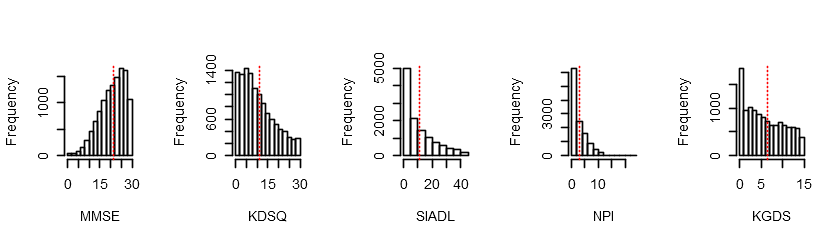

In [16]:
par(mfrow = c(1, 5))
hist(NP_test[,89], main="", xlab="MMSE")
abline(v=mean(NP_test[,89]), lty=3, col="red")
hist(NP_test[,106], main="", xlab="KDSQ")
abline(v=mean(NP_test[,106]), lty=3, col="red")
hist(NP_test[,107], main="", xlab="SIADL")
abline(v=mean(NP_test[,107]), lty=3, col="red")
hist(NP_test[,108], main="", xlab="NPI")
abline(v=mean(NP_test[,108]), lty=3, col="red")
hist(NP_test[,109], main="", xlab="KGDS")
abline(v=mean(NP_test[,109]), lty=3, col="red")

# 1-3 진단명에 따른 Histogram

In [17]:
options(repr.plot.height=3)

### 1. MMSE with DX (Mini-Mental State Examination, 환자용 검사지, 0~30점)
 - 치매환자가 평균적으로 낮은 점수를 가지는 성향이 있다.

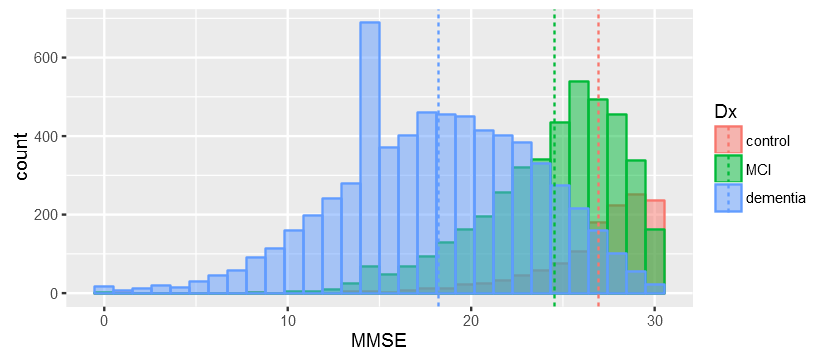

In [18]:
mmse.mu <- ddply(NP_test[,c(3,89)], "Dx", summarise, grp.mean=mean(MMSE))
p <- ggplot(NP_test[,c(3,89)], aes(x=MMSE, fill=Dx, color=Dx)) +
  geom_histogram(position="identity", alpha=0.5, bins = 30)
p+geom_vline(data=mmse.mu, aes(xintercept=grp.mean, color=Dx),
             linetype="dashed")

### 2.KDSQ with DX (보호자용 설문지, 0~30점)
 - 치매환자가 평균적으로 높은 성향이 있다.

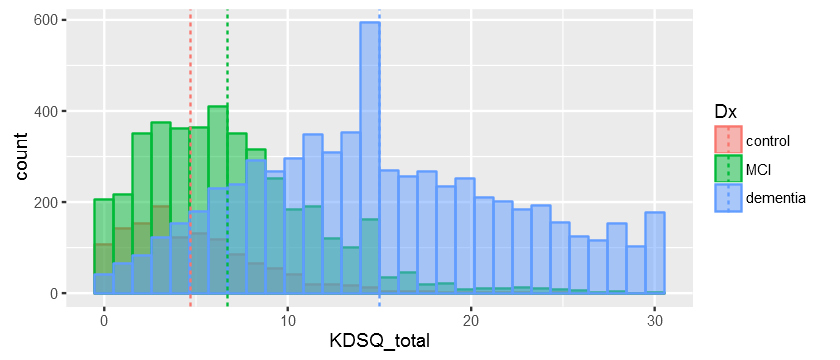

In [19]:
kdsq.mu <- ddply(NP_test[,c(3,106)], "Dx", summarise, grp.mean=mean(KDSQ_total))
p <- ggplot(NP_test[,c(3,106)], aes(x=KDSQ_total, fill=Dx, color=Dx)) +
  geom_histogram(position="identity", alpha=0.5, bins = 30)
p+geom_vline(data=kdsq.mu, aes(xintercept=grp.mean, color=Dx),
             linetype="dashed")

### 3. SIADL with DX (일상생활능력, 0~45점)
 - 치매환자가 평균적으로 높은 성향이 있다.

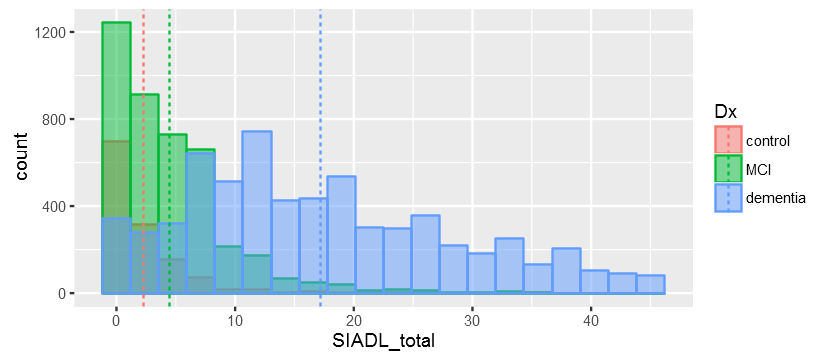

In [20]:
siadl.mu <- ddply(NP_test[,c(3,107)], "Dx", summarise, grp.mean=mean(SIADL_total))
p <- ggplot(NP_test[,c(3,107)], aes(x=SIADL_total, fill=Dx, color=Dx)) +
  geom_histogram(position="identity", alpha=0.5, bins = 20)
p+geom_vline(data=siadl.mu, aes(xintercept=grp.mean, color=Dx),
             linetype="dashed")

### 4. NPI with DX (정신증상평가, 0~24점)
 - 크게 변별력 있지는 않을 듯 하다.

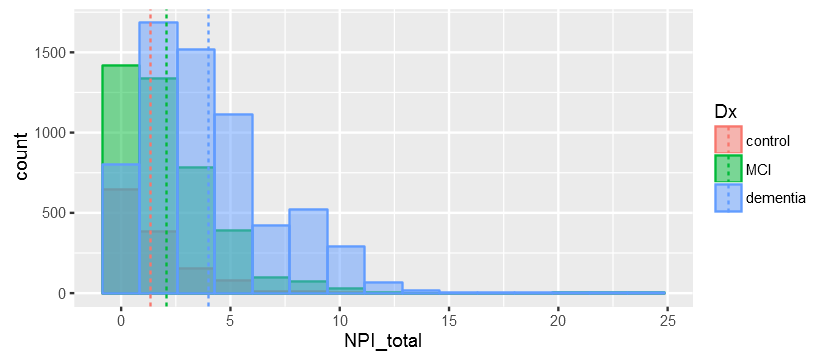

In [21]:
npi.mu <- ddply(NP_test[,c(3,108)], "Dx", summarise, grp.mean=mean(NPI_total))
p <- ggplot(NP_test[,c(3,108)], aes(x=NPI_total, fill=Dx, color=Dx)) +
  geom_histogram(position="identity", alpha=0.5, bins = 15)
p+geom_vline(data=npi.mu,aes(xintercept=grp.mean, color=Dx),
             linetype="dashed")

### 5.KGDS with DX (한국형노인우울, 0~15점)
 - 크게 변별력 있지는 않다.

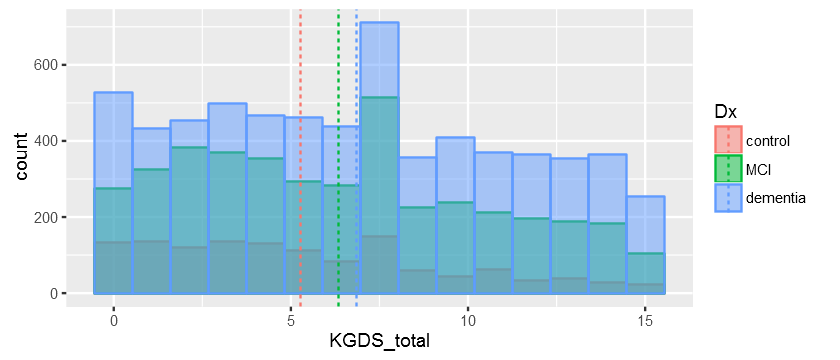

In [22]:
kgds.mu <- ddply(NP_test[,c(3,109)], "Dx", summarise, grp.mean=mean(KGDS_total))
p <- ggplot(NP_test[,c(3,109)], aes(x=KGDS_total, fill=Dx, color=Dx)) +
  geom_histogram(position="identity", alpha=0.5, bins = 15)
p+geom_vline(data=kgds.mu, aes(xintercept=grp.mean, color=Dx),
             linetype="dashed")

# 2-1. 진단명에 따른 의학적 분석 

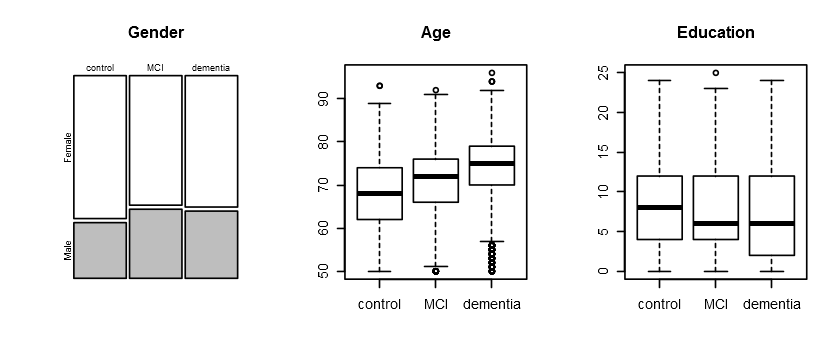

In [23]:
par(mfrow = c(1, 3))
plot(prop.table(table(NP_test$Dx, NP_test$Gender),1), type="h", col=c("white", "grey"),
     main="Gender")
#나이
boxplot(Age~Dx, data=NP_test, main="Age")

#학력
boxplot(Education~Dx, data=NP_test, main="Education")

#### 성별 

In [24]:
chisq.test(table(NP_test$Gender, NP_test$Dx)) #성별에 따라 연관이 있지 않다.


	Pearson's Chi-squared test

data:  table(NP_test$Gender, NP_test$Dx)
X-squared = 20.677, df = 2, p-value = 3.237e-05


#### 나이 

In [25]:
out=aov(Age~Dx, data=NP_test)
summary(out)
TukeyHSD(out)

               Df Sum Sq Mean Sq F value Pr(>F)    
Dx              2  55963   27982   489.3 <2e-16 ***
Residuals   11899 680512      57                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Age ~ Dx, data = NP_test)

$Dx
                     diff      lwr      upr p adj
MCI-control      3.199281 2.634300 3.764261     0
dementia-control 6.381330 5.840968 6.921693     0
dementia-MCI     3.182050 2.829340 3.534759     0


#### 학력 

In [26]:
out=aov(Education~Dx, data=NP_test)
summary(out)
TukeyHSD(out)

               Df Sum Sq Mean Sq F value Pr(>F)    
Dx              2   2759  1379.7    50.1 <2e-16 ***
Residuals   11899 327692    27.5                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Education ~ Dx, data = NP_test)

$Dx
                       diff       lwr        upr     p adj
MCI-control      -0.5105278 -0.902584 -0.1184716 0.0064387
dementia-control -1.3098831 -1.684856 -0.9349102 0.0000000
dementia-MCI     -0.7993553 -1.044111 -0.5546000 0.0000000


# 2-2. 진단명에 따른 의학적 분석 2

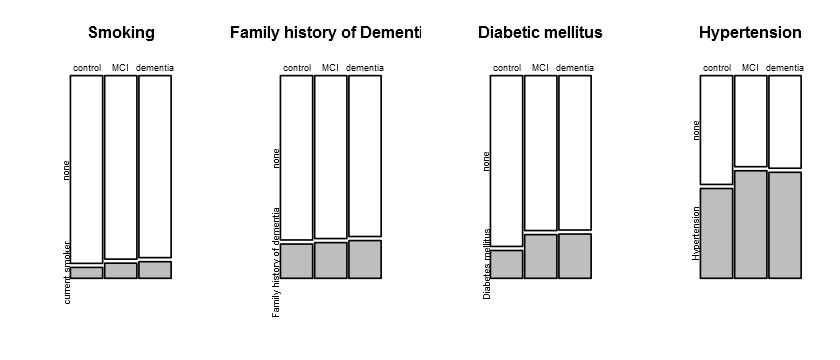

In [27]:
options(repr.plot.height=3)
par(mfrow = c(1, 4))
plot(prop.table(table(NP_test$Dx, NP_test$Smoking),1), type="h", col=c("white", "grey"),
     main="Smoking")
plot(prop.table(table(NP_test$Dx, NP_test$FHx_dementia),1), type="h", col=c("white", "grey"),
     main="Family history of Dementia")
plot(prop.table(table(NP_test$Dx, NP_test$Diabetes),1), type="h", col=c("white", "grey"),
     main="Diabetic mellitus")
plot(prop.table(table(NP_test$Dx, NP_test$HTN),1), type="h", col=c("white", "grey"),
     main="Hypertension")

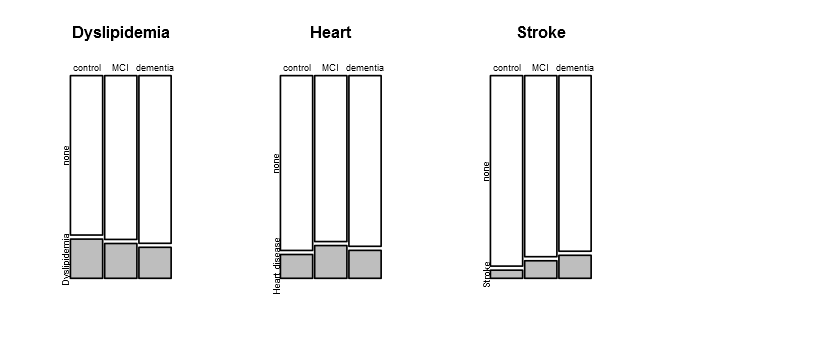

In [28]:
par(mfrow = c(1, 4))
plot(prop.table(table(NP_test$Dx, NP_test$Dyslipid),1), type="h", col=c("white", "grey"),
     main="Dyslipidemia")
plot(prop.table(table(NP_test$Dx, NP_test$Heart),1), type="h", col=c("white", "grey"),
     main="Heart")
plot(prop.table(table(NP_test$Dx, NP_test$Stroke),1), type="h", col=c("white", "grey"),
     main="Stroke")

- 종속변수가 범주형 자료(categorical data)인 경우에 사용하는 분석기법으로 카이제곱 검정(Chi-Squared Test)에 대해서 알아보도록 하겠습니다.
 - 적합도 검정(goodness of fit test) : 관측값들이 어떤 이론적 분포를 따르고 있는지를 검정. 한 개의 요인을 대상으로 함 

#### 가족력의 경우 유의한 수준으로 관계가 있다고 나왔다.

In [32]:
smoke <- chisq.test(table(NP_test$Smoking, NP_test$Dx)) 
FHx_dementia <- chisq.test(table(NP_test$FHx_dementia, NP_test$Dx)) # 가족력
Diabetes <- chisq.test(table(NP_test$Diabetes, NP_test$Dx))
HTN <- chisq.test(table(NP_test$HTN, NP_test$Dx))
Dyslipid <- chisq.test(table(NP_test$Dyslipid, NP_test$Dx))
Heart <- chisq.test(table(NP_test$Heart, NP_test$Dx))
Stroke <- chisq.test(table(NP_test$Stroke, NP_test$Dx))

In [34]:
data.frame(smoke$p.value, FHx_dementia$p.value, Diabetes$p.value, HTN$p.value, Dyslipid$p.value, Heart$p.value, Stroke$p.value)

,smoke.p.value,FHx_dementia.p.value,Diabetes.p.value,HTN.p.value,Dyslipid.p.value,Heart.p.value,Stroke.p.value
1,1.783693e-03,2.074858e-01,1.135500e-10,5.162253e-08,2.900544e-04,4.899564e-05,5.133916e-17


# 2-3. 진단명에 따른 인지기능검사

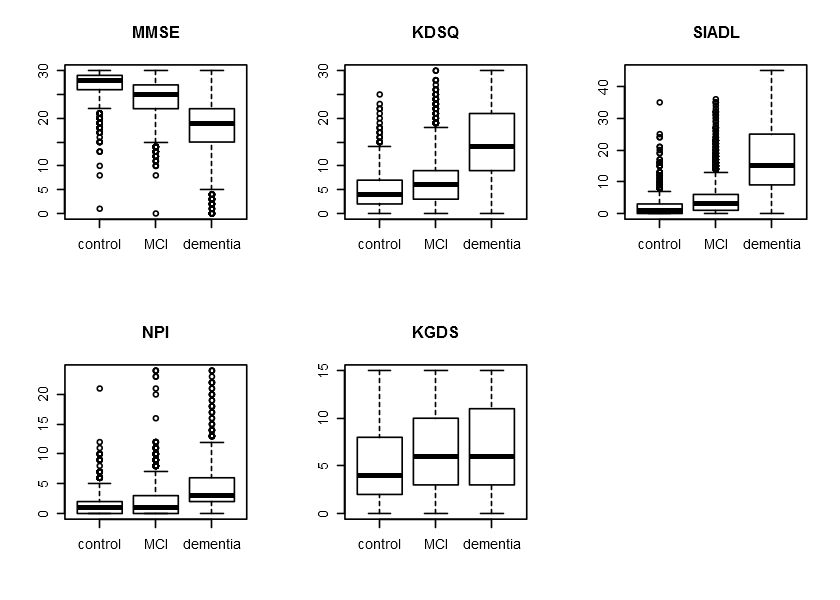

In [36]:
par(mfrow = c(2, 3))
options(repr.plot.height=5)
#MMSE
boxplot(MMSE~Dx, data=NP_test, main="MMSE")

#KDSQ
boxplot(KDSQ_total~Dx, data=NP_test, main="KDSQ")


#SIADL
boxplot(SIADL_total~Dx, data=NP_test, main="SIADL")


#NPI
boxplot(NPI_total~Dx, data=NP_test, main="NPI")


#KGDS
boxplot(KGDS_total~Dx, data=NP_test, main="KGDS")

### MMSE

In [37]:
out=aov(MMSE~Dx, data=NP_test)
summary(out)
TukeyHSD(out)

               Df Sum Sq Mean Sq F value Pr(>F)    
Dx              2 145838   72919    3272 <2e-16 ***
Residuals   11899 265167      22                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = MMSE ~ Dx, data = NP_test)

$Dx
                      diff       lwr       upr p adj
MCI-control      -2.417037 -2.769713 -2.064362     0
dementia-control -8.730340 -9.067648 -8.393032     0
dementia-MCI     -6.313303 -6.533473 -6.093132     0


### KDSQ

In [38]:
out=aov(KDSQ_total~Dx, data=NP_test)
summary(out)
TukeyHSD(out)

               Df Sum Sq Mean Sq F value Pr(>F)    
Dx              2 232245  116122    2969 <2e-16 ***
Residuals   11899 465384      39                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = KDSQ_total ~ Dx, data = NP_test)

$Dx
                      diff      lwr       upr p adj
MCI-control       2.009095 1.541875  2.476315     0
dementia-control 10.323759 9.876897 10.770621     0
dementia-MCI      8.314664 8.022985  8.606343     0


### SIADL

In [39]:
out=aov(SIADL_total~Dx, data=NP_test)
summary(out)
TukeyHSD(out)

               Df Sum Sq Mean Sq F value Pr(>F)    
Dx              2 523061  261530    3389 <2e-16 ***
Residuals   11899 918384      77                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = SIADL_total ~ Dx, data = NP_test)

$Dx
                      diff       lwr       upr p adj
MCI-control       2.245889  1.589551  2.902228     0
dementia-control 14.957671 14.329931 15.585410     0
dementia-MCI     12.711781 12.302038 13.121524     0


### NPI

In [40]:
out=aov(NPI_total~Dx, data=NP_test)
summary(out)
TukeyHSD(out)

               Df Sum Sq Mean Sq F value Pr(>F)    
Dx              2  13671    6835   849.8 <2e-16 ***
Residuals   11899  95710       8                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = NPI_total ~ Dx, data = NP_test)

$Dx
                      diff       lwr       upr p adj
MCI-control      0.7022861 0.4904044 0.9141679     0
dementia-control 2.6484682 2.4458189 2.8511175     0
dementia-MCI     1.9461821 1.8139072 2.0784569     0


### KGDS

In [41]:
out=aov(KGDS_total~Dx, data=NP_test)
summary(out)
TukeyHSD(out)

               Df Sum Sq Mean Sq F value Pr(>F)    
Dx              2   2850  1424.8   72.69 <2e-16 ***
Residuals   11899 233226    19.6                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = KGDS_total ~ Dx, data = NP_test)

$Dx
                      diff       lwr       upr p adj
MCI-control      1.0755121 0.7447591 1.4062651     0
dementia-control 1.5812138 1.2648729 1.8975548     0
dementia-MCI     0.5057017 0.2992172 0.7121863     0


# 3-1 MMSE의 Factor Analysis 를 통한 Structure확인
 - 각자의 설문지는 원래 각 질문별 Structure를 가지고 있다. 즉. 연관된 질문인지 아닌지, 이러한 질문들이 잘 짜여져있는지를 확인 
<img src="6.png" width=200>

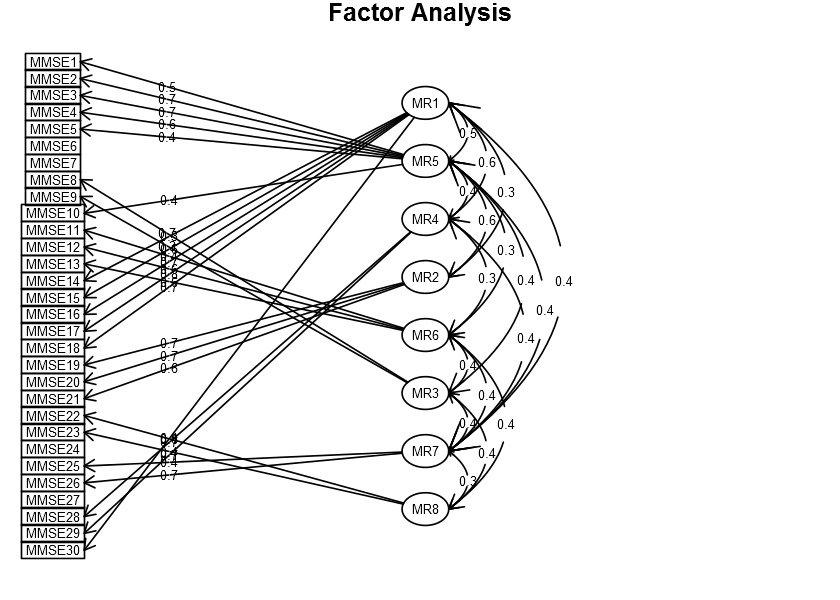

In [42]:
MMSE_fa <- fa(scale(NP_test[59:88]),8)
fa.diagram(MMSE_fa, sort=FALSE)

# 3-2 KDSQ의 Factor analysis를 통한 structure확인 
<img src="7.png" width=400>

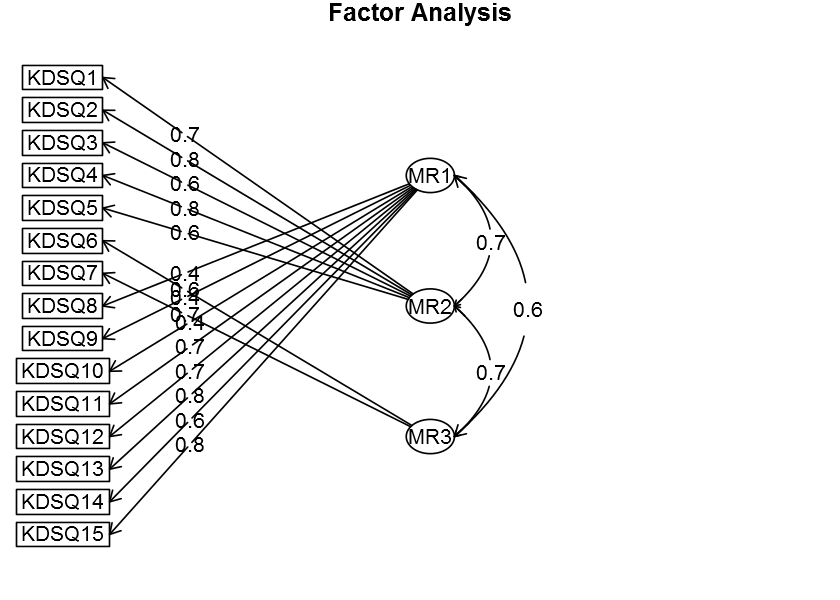

In [43]:
KDSQ_fa <- fa(scale(NP_test[17:31]),3)
fa.diagram(KDSQ_fa, sort=FALSE)

# 4-1. 인지기능검사도구의 Tree모형
 - Dx: control, MCI, dementia

<img src="8.PNG" width=800>

### 1차 Grouping 
  1. Control, MCI, Dementia 선별 검사 도구
    - MMSE 총점
    - SIADL 2,3,6,7,13,14,15
    - KDSQ 4,6,10,11,13,14,15
    - NPI 1,7
    - Education


In [44]:
NP_tools <-cbind(NP_test[c(3,6:8, 10:58,89,91:105)])
c5_options <- C5.0Control(winnow=TRUE, noGlobalPruning=FALSE, CF=0.010)
c5_model <- C5.0(Dx ~ ., data=NP_tools, control=c5_options, rules=FALSE, levels=1)
summary(c5_model)
#plot(c5_model)


Call:
C5.0.formula(formula = Dx ~ ., data = NP_tools, control = c5_options, rules
 = FALSE, levels = 1)


C5.0 [Release 2.07 GPL Edition]  	Fri Jan 20 08:18:39 2017
-------------------------------

Class specified by attribute `outcome'

Read 11902 cases (69 attributes) from undefined.data

15 attributes winnowed
Estimated importance of remaining attributes:

     17%  MMSE
      5%  KDSQ14
      4%  SIADL2
      4%  SIADL14
      2%  SIADL3
      1%  SIADL13
      1%  SIADL15
      1%  Diabetes
      1%  KDSQ10
     <1%  KDSQ2
     <1%  KDSQ13
     <1%  KDSQ8
     <1%  SIADL5
     <1%  Age
     <1%  KDSQ11
     <1%  KDSQ15
     <1%  Gender
     <1%  HTN
     <1%  Stroke
     <1%  KDSQ5
     <1%  SIADL7
     <1%  NPI12
     <1%  KDSQ3
     <1%  Education
     <1%  Smoking
     <1%  Heart
     <1%  KDSQ1
     <1%  KDSQ4
     <1%  KDSQ6
     <1%  KDSQ9
     <1%  SIADL6
     <1%  SIADL9
     <1%  SIADL10
     <1%  SIADL11
     <1%  NPI1
     <1%  NPI3
     <1%  NPI4
     <1%  NPI6
     <

In [45]:
NP_pred <- predict(c5_model, NP_tools, type="class")

In [46]:
confusionMatrix(NP_pred, NP_tools$Dx)

Confusion Matrix and Statistics

          Reference
Prediction control  MCI dementia
  control      426  289       10
  MCI          808 3025     1041
  dementia      57  831     5415

Overall Statistics
                                         
               Accuracy : 0.7449         
                 95% CI : (0.737, 0.7527)
    No Information Rate : 0.5433         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.547          
 Mcnemar's Test P-Value : < 2.2e-16      

Statistics by Class:

                     Class: control Class: MCI Class: dementia
Sensitivity                 0.32998     0.7298          0.8375
Specificity                 0.97182     0.7616          0.8366
Pos Pred Value              0.58759     0.6206          0.8591
Neg Pred Value              0.92261     0.8406          0.8123
Prevalence                  0.10847     0.3483          0.5433
Detection Rate              0.03579     0.2542          0.

# 4-2 인지기능 검사 도구 (추출된 모델)

In [49]:
NP_tools1 <-cbind(NP_test[c(4,6:8, 10:58,89,91:105)])
c5_options1 <- C5.0Control(winnow=TRUE, noGlobalPruning=FALSE, CF=0.010)
c5_model1 <- C5.0(Dx1 ~ ., data=NP_tools1, control=c5_options, rules=FALSE, levels=1)

summary(c5_model1)


Call:
C5.0.formula(formula = Dx1 ~ ., data = NP_tools1, control = c5_options, rules
 = FALSE, levels = 1)


C5.0 [Release 2.07 GPL Edition]  	Fri Jan 20 08:26:21 2017
-------------------------------

Class specified by attribute `outcome'

Read 11902 cases (69 attributes) from undefined.data

1 attribute winnowed
Estimated importance of remaining attributes:

      5%  MMSE
      1%  NPI3
     <1%  Gender
     <1%  Education
     <1%  Age
     <1%  Smoking
     <1%  FHx_dementia
     <1%  Diabetes
     <1%  HTN
     <1%  Dyslipid
     <1%  Heart
     <1%  Stroke
     <1%  KDSQ1
     <1%  KDSQ2
     <1%  KDSQ3
     <1%  KDSQ4
     <1%  KDSQ5
     <1%  KDSQ6
     <1%  KDSQ7
     <1%  KDSQ8
     <1%  KDSQ9
     <1%  KDSQ10
     <1%  KDSQ11
     <1%  KDSQ12
     <1%  KDSQ13
     <1%  KDSQ14
     <1%  KDSQ15
     <1%  SIADL1
     <1%  SIADL2
     <1%  SIADL3
     <1%  SIADL4
     <1%  SIADL5
     <1%  SIADL6
     <1%  SIADL7
     <1%  SIADL8
     <1%  SIADL9
     <1%  SIADL10
     <1%  SIA

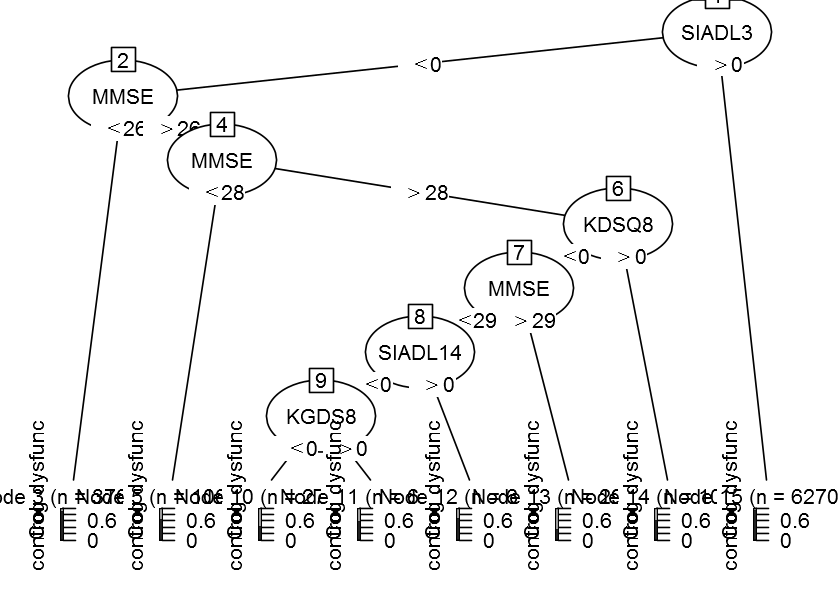

In [50]:
plot(c5_model1)

### 정확도 90%로 상승.

In [52]:
NP_pred1 <- predict(c5_model1, NP_tools1, type="class")
NP_pred1_prob <- predict(c5_model, NP_tools1, type="prob")
NP_pred1_ROC <- prediction(NP_pred1_prob[,2], NP_tools1$Dx1)
confusionMatrix(NP_pred1, NP_tools1$Dx1, positive = "Cog dysfunc")

Confusion Matrix and Statistics

             Reference
Prediction    control Cog dysfunc
  control         344         226
  Cog dysfunc     947       10385
                                          
               Accuracy : 0.9014          
                 95% CI : (0.8959, 0.9067)
    No Information Rate : 0.8915          
    P-Value [Acc > NIR] : 0.0002261       
                                          
                  Kappa : 0.3248          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9787          
            Specificity : 0.2665          
         Pos Pred Value : 0.9164          
         Neg Pred Value : 0.6035          
             Prevalence : 0.8915          
         Detection Rate : 0.8725          
   Detection Prevalence : 0.9521          
      Balanced Accuracy : 0.6226          
                                          
       'Positive' Class : Cog dysfunc     
                         

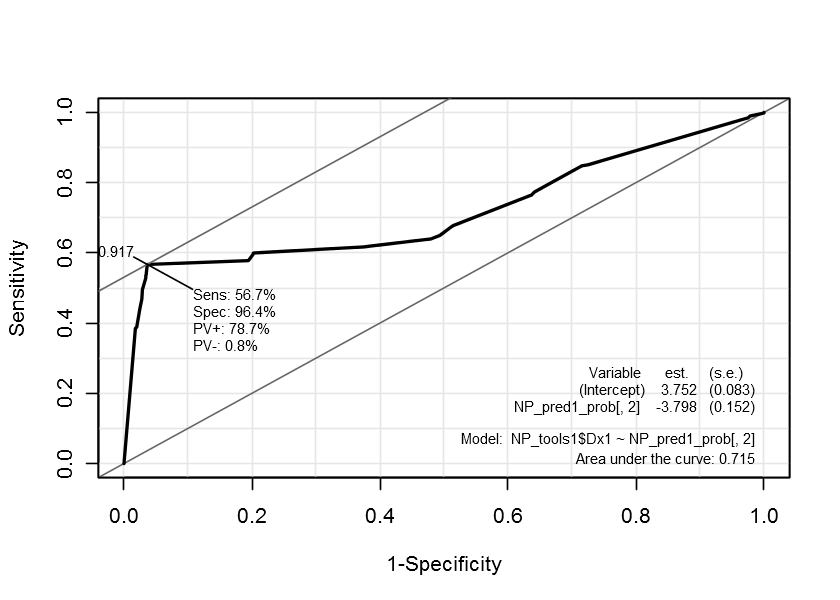

In [53]:
ROC(form=NP_tools1$Dx1~NP_pred1_prob[,2], plot="ROC")

# 4-3.기존 도구와의 비교 

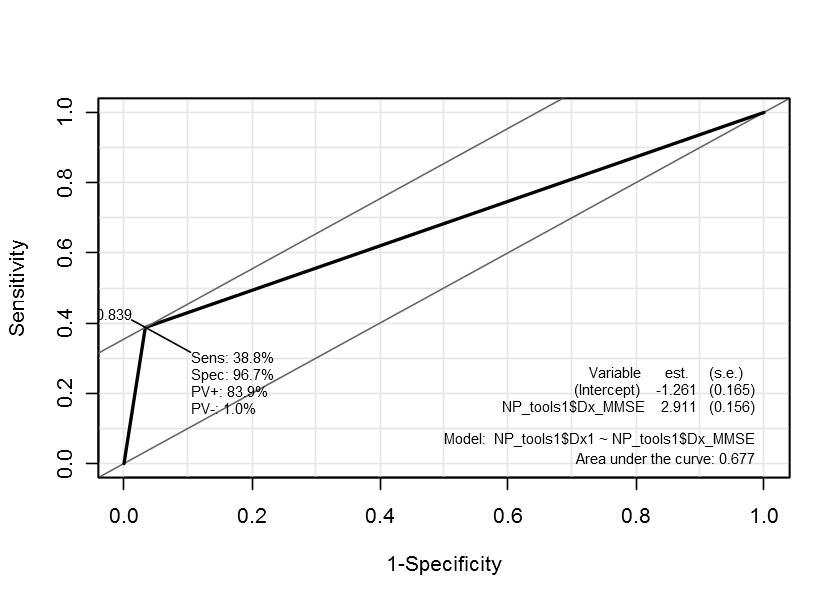

In [55]:
NP_tools1$Dx_MMSE <- ifelse(NP_tools1$MMSE>=20, 1, 2) #MMSE의 기준점 
ROC(form=NP_tools1$Dx1~NP_tools1$Dx_MMSE, plot="ROC")

 - 기존의 모델 모다 선별된 도구 점수로 만든 모델의 기능이 더 좋다
  - AUC(선별) 0.715 > AUC(기존) 0.677

In [56]:
roc1 <- roc(NP_tools1$Dx1, NP_pred1_prob[,2])
roc2 <- roc(NP_tools1$Dx1, NP_tools1$Dx_MMSE)
roc.test(roc1, roc2) #2개의 ROC 비교 


	Bootstrap test for two correlated ROC curves

data:  roc1 and roc2
D = 6.956, boot.n = 2000, boot.stratified = 1, p-value = 3.5e-12
alternative hypothesis: true difference in AUC is not equal to 0
sample estimates:
AUC of roc1 AUC of roc2 
  0.7149780   0.6771546 


# 결론
    인지기능 선별검사도구에는 MMSE, KDSQ, SIADL 등이 많이 사용되는데, 선별검사 목적으로 실제 임상에서 
    이용하기에는 시간과 노력이 많이 든다. 


## 선별검사도구의 간편화
 - 기존의 방법: MMSE + KDSQ 15문항 + SIADL 15문항 + NPI 12문항 + KGDS 15문항
 - 간편화 1: MMSE + KDSQ 7문항 + SIADL 7문항 + NPI 2문항   => Control: MCI: Dementia
 - 간편화 2: MMSE + KDSQ 1문항 + SIADL 2문항   => Control: Cognitive dysfunction
